In [34]:
from utils import load_dataset
import matplotlib.pyplot as plt
from pathlib import Path

import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim

import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split


In [35]:
def train_and_evaluate_model(model, train_loader, val_loader, save_path, num_epochs=10, learning_rate=0.001):
    
    # Loss criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

    liste_epoch = []
    liste_train_loss = []
    liste_val_loss = []
    liste_train_acc = []
    liste_val_acc = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Training mode
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = correct_train / total_train

        # Validation
        model.eval()  # Evaluation mode
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = correct_val / total_val

        # Calculate average loss per epoch
        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)

        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}')

        # Save values for later analysis
        liste_epoch.append(epoch+1)
        liste_train_loss.append(train_loss)
        liste_val_loss.append(val_loss)
        liste_train_acc.append(train_accuracy)
        liste_val_acc.append(val_accuracy)

    with save_path.open('wb') as fp :
        torch.save(model,fp)

    return liste_epoch, liste_train_loss, liste_val_loss, liste_train_acc, liste_val_acc


def calculate_accuracy(model, test_loader):
    correct = 0
    total = 0

    model.eval()  # Mettre le modèle en mode d'évaluation

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Précision sur les données de test: {accuracy:.2f}%')

In [36]:
SEED = 42
torch.manual_seed(SEED)
TRAIN_RATIO = 0.8
N_CLASSES = 2

save_path = Path("Models\model_resnet18_c.pch")

In [37]:
train_images, train_labels = load_dataset(test=False, color=True)
test_images, test_labels = load_dataset(test=True, color=True)

In [38]:
B, W, H, C = train_images.shape
train_images = train_images.reshape((B, C, W, H))

train_images.shape

(800, 3, 224, 224)

In [39]:
B, W, H, C = test_images.shape
test_images = test_images.reshape((B, C, W, H))

print(test_images.shape)

test_images = torch.tensor(test_images, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.long)

test_dataset = TensorDataset(test_images, test_labels)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

(200, 3, 224, 224)


In [40]:
# Diviser les données en ensembles d'entraînement et de validation
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42)

# Transformations

train_images = torch.tensor(train_images, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.long)

val_images = torch.tensor(val_images, dtype=torch.float32)
val_labels = torch.tensor(val_labels, dtype=torch.long)

# Appliquer les transformations et créer des DataLoader
train_data = TensorDataset(train_images, train_labels)
val_data = TensorDataset(val_images, val_labels)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

In [41]:
# Charger un modèle pré-entraîné (ResNet18)
model_resnet18 = models.resnet18(pretrained=True)

# Geler les paramètres (poids) de toutes les couches du modèle
for param in model_resnet18.parameters():
    param.requires_grad = False

# Remplacer la dernière couche de classification
num_ftrs = model_resnet18.fc.in_features
model_resnet18.fc = nn.Linear(num_ftrs, 2)  # 2 classes pour la sortie

liste_epoch, liste_train_loss, liste_val_loss, liste_train_acc, liste_val_acc = train_and_evaluate_model(model_resnet18, train_loader, val_loader, save_path = save_path, num_epochs=50, learning_rate=0.001)

Epoch 1, Train Loss: 23.6510, Val Loss: 27.1001, Train Acc: 0.5281, Val Acc: 0.5000
Epoch 2, Train Loss: 20.8517, Val Loss: 20.2467, Train Acc: 0.6344, Val Acc: 0.6750
Epoch 3, Train Loss: 19.7343, Val Loss: 19.1174, Train Acc: 0.6516, Val Acc: 0.6687
Epoch 4, Train Loss: 18.3576, Val Loss: 18.9377, Train Acc: 0.7141, Val Acc: 0.6500
Epoch 5, Train Loss: 19.0559, Val Loss: 18.6079, Train Acc: 0.6937, Val Acc: 0.6875
Epoch 6, Train Loss: 16.8629, Val Loss: 18.5475, Train Acc: 0.7531, Val Acc: 0.6937
Epoch 7, Train Loss: 16.4834, Val Loss: 18.2673, Train Acc: 0.7578, Val Acc: 0.7125
Epoch 8, Train Loss: 17.8515, Val Loss: 19.0945, Train Acc: 0.7000, Val Acc: 0.6875
Epoch 9, Train Loss: 16.7146, Val Loss: 17.7931, Train Acc: 0.7328, Val Acc: 0.7000
Epoch 10, Train Loss: 16.5708, Val Loss: 17.9257, Train Acc: 0.7562, Val Acc: 0.7250
Epoch 11, Train Loss: 15.8086, Val Loss: 17.7129, Train Acc: 0.7766, Val Acc: 0.7125
Epoch 12, Train Loss: 15.1635, Val Loss: 18.0365, Train Acc: 0.7812, Val A

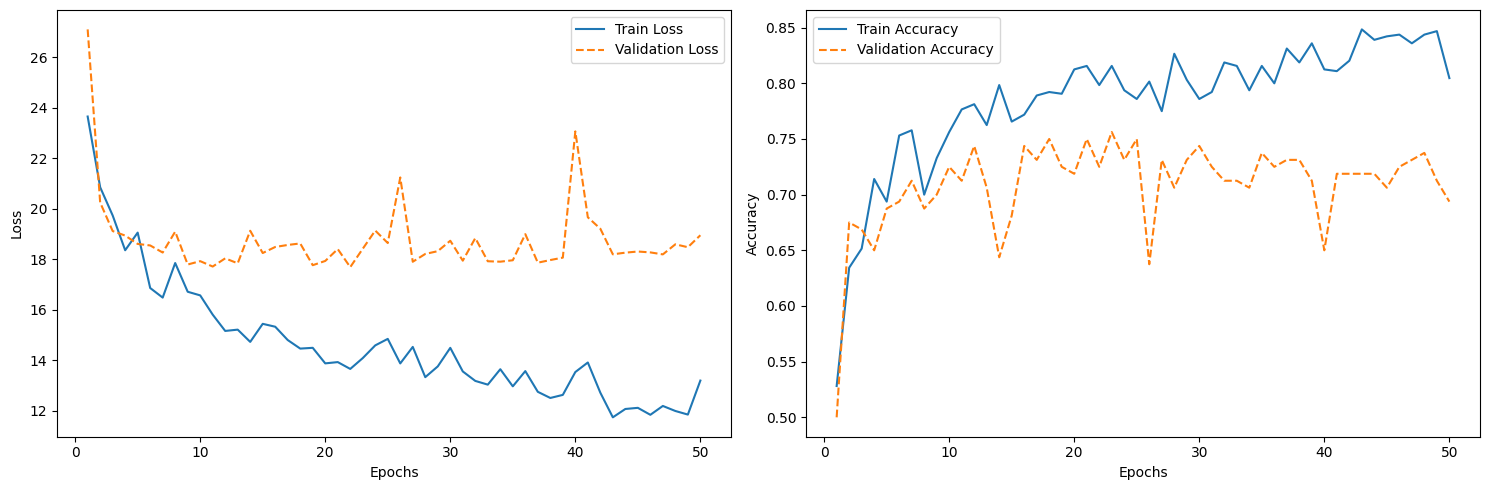

Précision sur les données de test: 69.00%


In [42]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 2)  # 2 rows, 1 column, this is the first subplot
plt.plot(liste_epoch, liste_train_acc, label='Train Accuracy')
plt.plot(liste_epoch, liste_val_acc, label='Validation Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Subplot for Loss
plt.subplot(1, 2, 1)  # 2 rows, 1 column, this is the second subplot
plt.plot(liste_epoch, liste_train_loss, label='Train Loss')
plt.plot(liste_epoch, liste_val_loss, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

calculate_accuracy(model_resnet18, test_loader)